# Investigate the impact of miscentering on shear profiles

_the LSST-DESC CLMM team_

This notebook demonstrates the impact of taking wrong cluster centers to construct and derive the mass from reduced shear profiles with`CLMM`. This notebook is based on notebook "demo_dataops_functionality.ipynb". 


In [15]:
import matplotlib.pyplot as plt
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
import clmm.galaxycluster as gc
from numpy import random 
import numpy as np
import clmm.dataops as da
from clmm.support.sampler import fitters

from astropy.coordinates import SkyCoord
import astropy.units as u

Make sure we know which version we're using

In [16]:
clmm.__version__

'1.0.9'

### Define cosmology object

In [17]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
np.random.seed(11)

## 1. Generate cluster objects from mock data
In this example, the mock data only include galaxies drawn from redshift distribution.

Define toy cluster parameters for mock data generation

In [20]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngal_density = 50 #gal/arcmin2 
cluster_ra = 20.
cluster_dec = 40.
zsrc_min = cluster_z + 0.1 # we only want to draw background galaxies
field_size = 20 #Mpc

ideal_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            'chang13',delta_so=200,
                                            massdef="mean",
                                            zsrc_min=zsrc_min,
                                            ngal_density=ngal_density, 
                                            cluster_ra=cluster_ra,
                                            cluster_dec = cluster_dec,
                                            field_size=field_size)

We want to load this mock data into several CLMM cluster objects centered between (-0.2, -0.2) - (0.2, 0.2) degrees and save them in a list. The user can change the number of cluster centers if desired. We set the first center to (0,0) for comparison reasons, which corresponds to a == 0.

In [21]:
center_number = 5
cluster_list = []
coord = []

for a in range (0, center_number):
    if a == 0:
        cluster_ra_new = cluster_ra
        cluster_dec_new = cluster_dec
    else:
        cluster_ra_new  = random.uniform(cluster_ra - 0.2, cluster_ra + 0.2)
        cluster_dec_new = random.uniform(cluster_dec - 0.2, cluster_dec + 0.2)
        
    cl = clmm.GalaxyCluster(cluster_id, cluster_ra_new, cluster_dec_new,
                               cluster_z, ideal_data_z)
    
    print("Cluster info = ID:", cl.unique_id, "; ra:", "%.2f" %cl.ra,
          "; dec:", "%.2f" %cl.dec, "; z_l :", cl.z)
    print("The number of source galaxies is :", len(cl.galcat))
    
    cluster_list.append(cl)
    coord.append(SkyCoord(cl.ra*u.deg, cl.dec*u.deg))

Cluster info = ID: Awesome_cluster ; ra: 20.00 ; dec: 40.00 ; z_l : 0.3
The number of source galaxies is : 237965
Cluster info = ID: Awesome_cluster ; ra: 19.81 ; dec: 39.99 ; z_l : 0.3
The number of source galaxies is : 237965
Cluster info = ID: Awesome_cluster ; ra: 20.02 ; dec: 40.20 ; z_l : 0.3
The number of source galaxies is : 237965
Cluster info = ID: Awesome_cluster ; ra: 19.84 ; dec: 39.95 ; z_l : 0.3
The number of source galaxies is : 237965
Cluster info = ID: Awesome_cluster ; ra: 20.00 ; dec: 40.12 ; z_l : 0.3
The number of source galaxies is : 237965


In [22]:
#Offset of the different cluster centers from the position 0,0 (in degree)
offset = [coord[0].separation(coord[i]).value for i in range(5)]

## 2. Basic checks and plots 
- galaxy positions
- redshift distribution

For a better visualization, we plot all the different cluster centers, represented by the red dots.

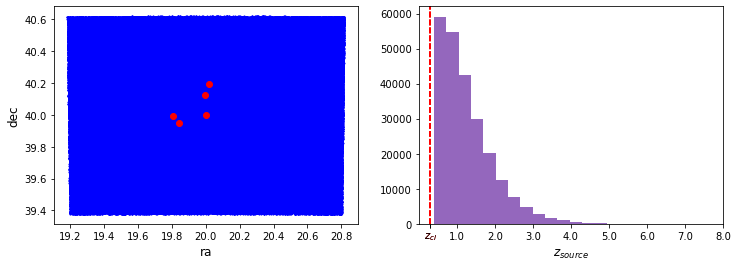

In [23]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

for cl in cluster_list:
    ax[0].scatter(cl.galcat['ra'], cl.galcat['dec'], color='blue', s=1, alpha=0.3)
    ax[0].plot(cl.ra, cl.dec, 'ro')
    ax[0].set_ylabel('dec', fontsize="large")
    ax[0].set_xlabel('ra', fontsize="large")

    hist = ax[1].hist(cl.galcat['z'], bins=20)[0]

    ax[1].axvline(cl.z, c='r', ls='--')
    ax[1].set_xlabel('$z_{source}$', fontsize="large")
    xt = {t:f'{t}' for t in ax[1].get_xticks() if t!=0}
    xt[cl.z] ='$z_{cl}$'
    xto = sorted(list(xt.keys())+[cl.z])
    ax[1].set_xticks(xto)
    ax[1].set_xticklabels(xt[t] for t in xto)
    ax[1].get_xticklabels()[xto.index(cl.z)].set_color('red')
    plt.xlim(0, max(xto))
    
plt.show()

## 3. Compute the center effect on the shear profiles

Next, we generate the profiles for all the Cluster objects and save the profiles into a list. We also save the `gt`, `gx`, and `radius` columns of each `profile` into lists, so we can make a plot of these components. 


In [24]:
bin_edges = make_bins(0.3, 6, 10) # We want to specify the same bins for all the centers.

profile_list = []

for cl in cluster_list:
    theta, e_t, e_x = compute_tangential_and_cross_components(
                    ra_lens=cl.ra, dec_lens=cl.dec,
                    ra_source=cl.galcat['ra'], dec_source=cl.galcat['dec'],
                    shear1=cl.galcat['e1'], shear2=cl.galcat['e2'])
    cl.compute_tangential_and_cross_components(add=True)
    cl.make_radial_profile("Mpc", cosmo=cosmo,bins=bin_edges, include_empty_bins=False)
    profile_list.append(cl.profile)

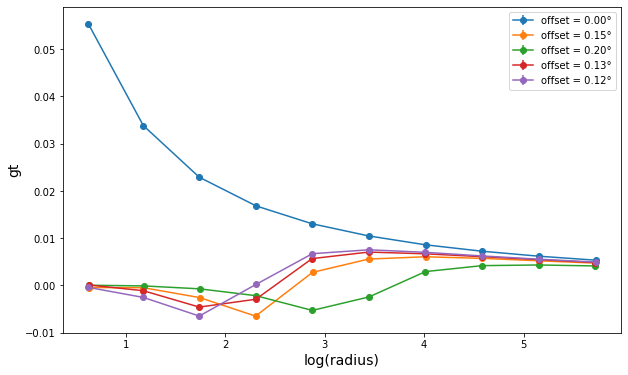

In [25]:
fig = plt.figure(figsize=(10, 6))

for a in range (0, len(profile_list)):
    fig.gca().errorbar(profile_list[a]['radius'],profile_list[a]['gt'],profile_list[a]['gt_err'],linestyle='-', 
    marker='o', label =f'offset = {"{:.2f}".format(offset[a])}°')

plt.xlabel('log(radius)', size=14)
plt.ylabel('gt', size=14)

plt.legend()
plt.show()

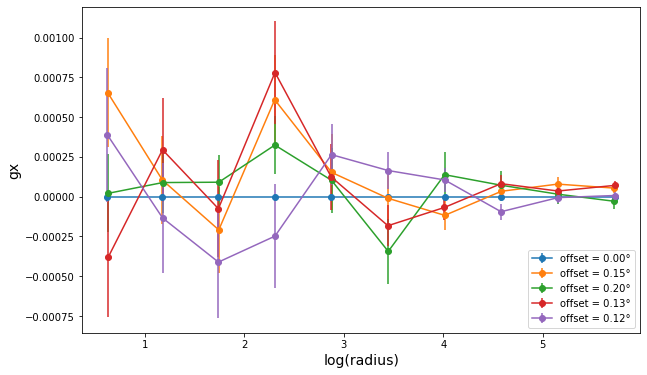

In [27]:
fig2 = plt.figure(figsize=(10, 6))

for a in range (0, len(profile_list)):
    fig2.gca().errorbar(profile_list[a]['radius'],profile_list[a]['gx'],profile_list[a]['gx_err'],linestyle='-', 
    marker='o', label =f'offset = {"{:.2f}".format(offset[a])}°')
    
plt.xlabel('log(radius)', size=14)
plt.ylabel('gx', size=14)
plt.legend(loc=4)

plt.show()

Since we consider GalaxyCluster objects with no shape noise or photo-z errors, the center (0,0) gives the expected result `gx = 0`, by construction. For the other cluster centers, we can see that the cross shear term average to zero as expected, but the profiles are noisier. 

## 4. Compute the center effect by fitting the Halo mass

In this last step, we compute the fitting Halo mass with the `nfw` model and, using a plot, compare the impact of the Cluster centers on the weak lensing mass.

In [28]:
from clmm.support.sampler import samplers

The function below defines the Halo model. For further information, check the notebook "Example2_Fit_Halo_Mass_to_Shear_Catalog.ipynb" 

In [29]:
logm_0 = random.uniform(13., 17., 1)[0]
def shear_profile_model(r, logm, z_src):
    m = 10.**logm
    gt_model = clmm.compute_reduced_tangential_shear(r,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')    
    return gt_model

The fitted mass is : 8.76e+14 for the offset distance: 0.00 }°
The fitted mass is : 4.38e+14 for the offset distance: 0.15 }°
The fitted mass is : 9.40e+13 for the offset distance: 0.20 }°
The fitted mass is : 5.56e+14 for the offset distance: 0.13 }°
The fitted mass is : 5.99e+14 for the offset distance: 0.12 }°


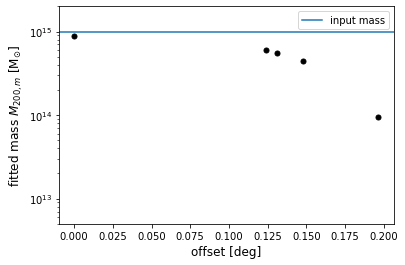

In [30]:
for a in range(0, len(cluster_list)):
    popt,pcov = fitters['curve_fit'](lambda r, logm:shear_profile_model(r, logm, profile_list[a]['z']), 
                    profile_list[a]['radius'], 
                    profile_list[a]['gt'], 
                    profile_list[a]['gt_err'], bounds=[13.,17.])

    m_est1 = 10.**popt[0]
    m_est_err1 =  m_est1 * np.sqrt(pcov[0][0]) * np.log(10) # convert the error on logm to error on m

    print(f"The fitted mass is :","%.2e"%m_est1, "for the offset distance:", "%.2f"%offset[a],"}°")
    plt.errorbar(offset[a], m_est1, yerr = m_est_err1, fmt='.', color='black', markersize=10)#, label=f'Offset:{"{:.2f}".format(offset[a])}°')

plt.xlabel('offset [deg]', size=12)
plt.ylabel('fitted mass $M_{200,m}$ [M$_{\odot}$]', size=12)
plt.yscale('log')
plt.ylim([5.e12,2.e15])
plt.axhline(cluster_m, label = "input mass")
plt.legend(loc="best")
plt.show()


We can see that for cluster centers differing from (0,0), we have a negative effect on the lensing mass, which increases with the offset distance.